# Time Series Analysis - Sunspots

The objective of this notebook is to test different models of forecast and compare their accuracy. [The database ](https://www.kaggle.com/datasets/robervalt/sunspots?resource=download) contains the Monthly Mean Total Sunspot Number from 1749/01/01 to 2021/01/31 and can be found on Kaggle. 

"Just to to give a little context about Sunspots: Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle."

Source: https://en.wikipedia.org/wiki/Sunspot



## Table of contents

1. **Importing Libraries**
2. **Creating Functions**
3. **Importing Data**
4. **Visualizing Data**
5. **Testing for Stationarity**
6. **Time Series Decomposition**
7. **Forecast Models**    
    7.1. **Naive Model**    
    7.2. **Mean Model**    
    7.3. **Exponential Smoothing**    
    7.4. **ARIMA**
8. **Conclusion: Comparing Forecast Models Accuracy**
9. **Bibliography**

***

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from statsmodels.tsa.arima.model import ARIMAResults, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

***

## 2. Creating Functions

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #t=132 was used due to the 11 year solar cycle
    rolmean = timeseries.rolling(132).mean() 
    rolstd = timeseries.rolling(132).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [3]:
def forecast_error(test_data, model_data, model_name = 'model_name'):
    
    rmse = np.sqrt(np.mean((test_data - model_data)**2)).round(2)
    mae = np.mean(np.abs(test_data - model_data)).round(2) 
    
    results_dict = {'Model': model_name, 'RMSE': rmse, 'MAE': mae}

    return results_dict

In [4]:
def aic_finder(timeseries, d=0, n=5):

    results = []

    #looping through all possible values of p, q
    for p in range(0,4):
        for q in range(0,3):
            model_fit = ARIMA(timeseries, order=(p,q,d)).fit()
            aic = int(model_fit.aic)

            results.append({'p, q, d':(p,q,d), 'AIC':aic})

    # Ordering by AIC value descending
    results_ord = sorted(results, key = lambda i: i['AIC'])

    # Saving in a dataframe for better visualization
    results_df = pd.DataFrame(results_ord)
    
    return results_df.head(n);

***

## 3. Importing Data

In [5]:
df = pd.read_csv('Sunspots.csv', parse_dates=['Date'], index_col='Date')['Monthly Mean Total Sunspot Number']
df.tail()

Date
2020-09-30     0.6
2020-10-31    14.4
2020-11-30    34.0
2020-12-31    21.8
2021-01-31    10.4
Name: Monthly Mean Total Sunspot Number, dtype: float64

In [6]:
# Checking the data
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Series name: Monthly Mean Total Sunspot Number
Non-Null Count  Dtype  
--------------  -----  
3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


In [7]:
df.describe()

count    3265.000000
mean       81.778775
std        67.889277
min         0.000000
25%        23.900000
50%        67.200000
75%       122.500000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

In [8]:
df.isna().any()

False

In [9]:
df.index

DatetimeIndex(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
               '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
               '1749-09-30', '1749-10-31',
               ...
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31'],
              dtype='datetime64[ns]', name='Date', length=3265, freq=None)

It seems that our data is ok! If we encounter any trouble we can go back and look with more detail.

***

## 4. Visualizing Data

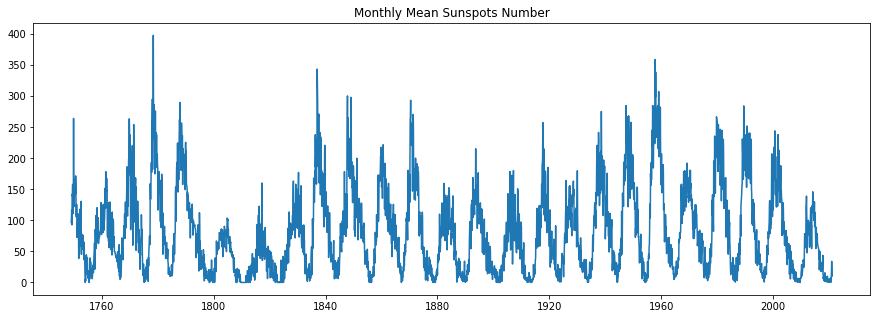

In [10]:
plt.figure(figsize=(15,5))
plt.title('Monthly Mean Sunspots Number')
plt.plot(df)

plt.show()

***

## 5. Testing for Stationarity

To check weather the time series is Stationary or not we are going to use two different approaches:  
1. The first one is a visual method, we are going to plot the Roling Mean and the Standard Deviation (note that we are using t = 132, since the solar cycle is about 11 years. We want to see if the mean and the variance are constant. 
2. The second method is called [Dickey-Fuller test](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/). This is a statistical test for checking stationarity. First, we consider the null hypothesis: the time series is non-stationary. If the test statistics are less than the critical value, we can reject the null hypothesis and say that the time series is stationary. 

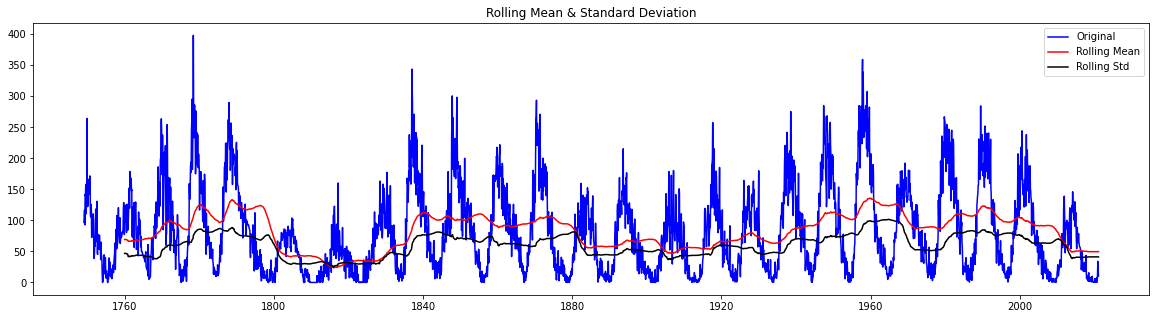

Results of Dickey-Fuller Test:
Test Statistic                -1.049705e+01
p-value                        1.108552e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64


In [11]:
test_stationarity(df)

Since the null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. In addition, looking to the Rolling Mean and the Rolling Std, there are small variations with time but no specific trend, which reinforces that our Time Series is indeed stationary. 
    
Now that we are sure that the Time Series is stationary, we can go on with our analysis. 

***

## 6. Time Series Decomposition

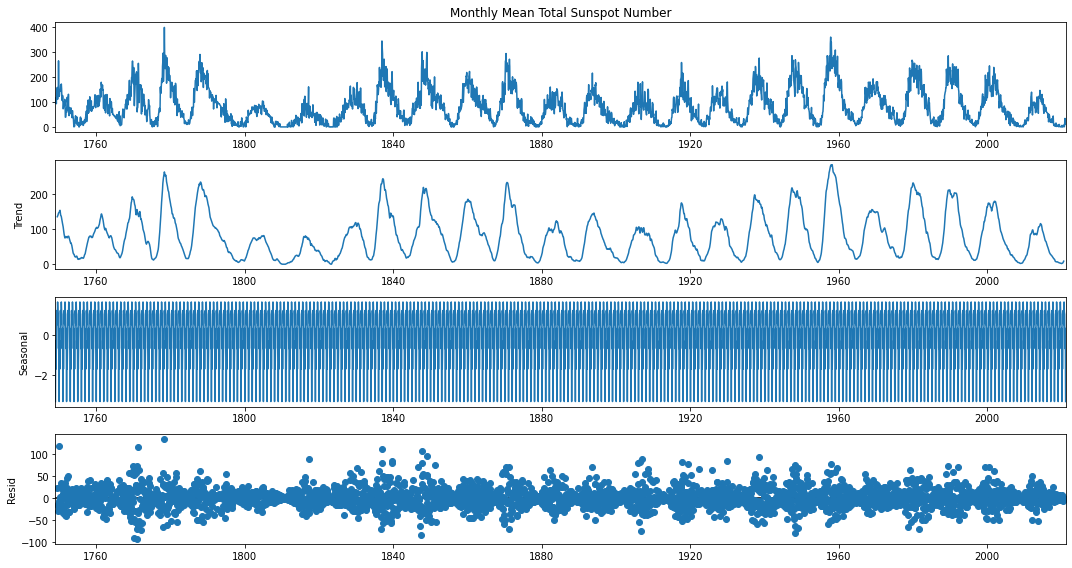

In [12]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')

matplotlib.rcParams['figure.figsize'] = 15, 8
decomposition.plot()
plt.show()

As we decompose the Time Series, we can better observe the trend, seasonality and the residuals. From the graphics above, we can infer that the series has no trend and no seasonality. In addition, the residuals are balanced, which is a good sign.    

note: since we have some values near zero, we cannot use the multiplicative model to decompose the Time Series.

***

# 7. Forecast Models

For the forecast models, we will use the first 80% of the dataset to train our model 'train data', and the last 20% to test the accuracy of the forecast. 

In [13]:
# Split time series data into training and test set

train_length = int(len(df)*0.8)

train_data = df[: train_length] # train with the first 80% of the data
test_data = df[train_length:] # test with the last 20% of the data

### 7.1. Naive Model

For naïve forecasts, we simply set all forecasts to be the value of the last observation

In [65]:
naive_model = test_data.copy()
naive_model = naive_model.apply(lambda x: train_data[-1])

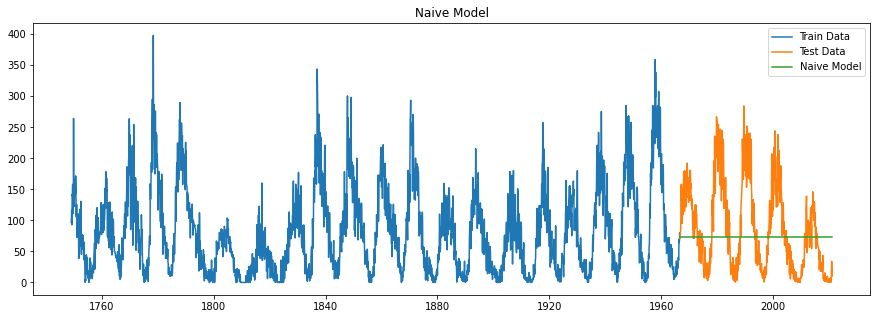

In [66]:
# Plotting the Naive Model Graph

plt.figure(figsize=(15,5))
plt.title('Naive Model')
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.plot(naive_model, label='Naive Model')
plt.legend(loc='best')
plt.show()

In [67]:
forecast_error(naive_model, test_data)

{'Model': 'model_name', 'RMSE': 70.7, 'MAE': 57.97}

### 7.2. Mean Model

In [14]:
y_hat_mean = test_data.copy()
y_hat_mean = y_hat_mean.apply(lambda x: df.mean())

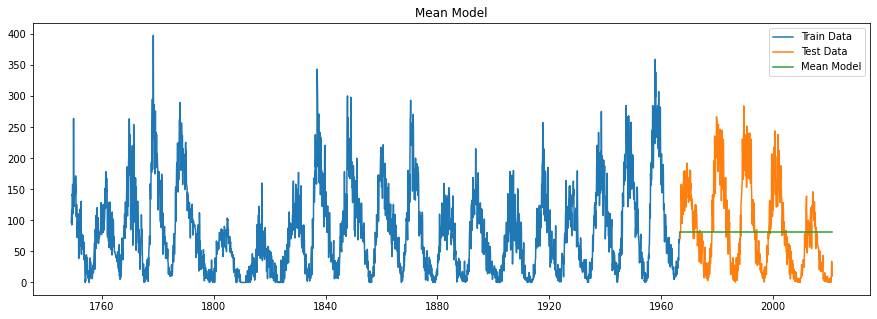

In [15]:
# Plotting the Mean Model Graph

plt.figure(figsize=(15,5))
plt.title('Mean Model')
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.plot(y_hat_mean, label='Mean Model')
plt.legend(loc='best')
plt.show()

#### Calculating RMSE and MAE

In [16]:
forecast_error(test_data, y_hat_mean, 'Mean Model')

{'Model': 'Mean Model', 'RMSE': 69.44, 'MAE': 58.36}

<hr>

### 7.3. Exponencial smoothing

In [17]:
fit_1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2)
fit_2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.6)
fit_3 = SimpleExpSmoothing(train_data).fit() #auto

In [18]:
# We are using steps=653 because is the lenght of the test data. 
fcast_1 = fit_1.forecast(653)
fcast_2 = fit_2.forecast(653)
fcast_3 = fit_3.forecast(653)

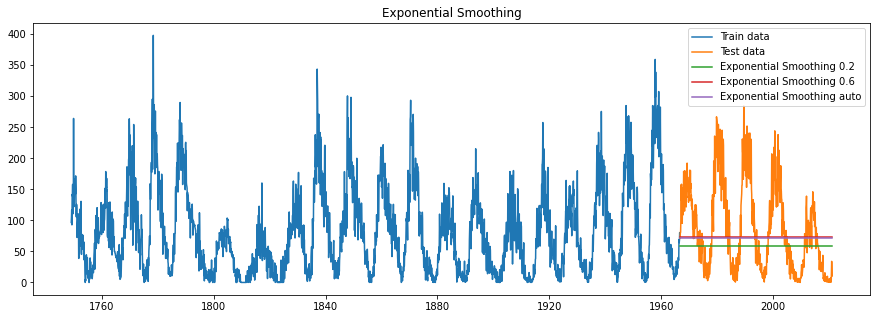

In [19]:
# Plotting the Exponential Smoothing Graph
plt.rcParams.update({'figure.figsize':(15,5)})

plt.title('Exponential Smoothing')
plt.plot(train_data, label='Train data')
plt.plot(test_data, label='Test data')
plt.plot(fcast_1, label='Exponential Smoothing 0.2')
plt.plot(fcast_2, label='Exponential Smoothing 0.6')
plt.plot(fcast_3, label='Exponential Smoothing auto')
plt.legend(loc='best')
plt.show()

#### Calculating RMSE, MAE and MAPE

In [20]:
forecast_error(test_data, fcast_1, 'Exponencial_Smoothing_01')


{'Model': 'Exponencial_Smoothing_01', 'RMSE': 75.02, 'MAE': 58.98}

In [21]:
forecast_error(test_data, fcast_2, 'Exponencial_Smoothing_02')

{'Model': 'Exponencial_Smoothing_02', 'RMSE': 70.58, 'MAE': 57.97}

In [22]:
forecast_error(test_data, fcast_3, 'Exponencial_Smoothing_03')

{'Model': 'Exponencial_Smoothing_03', 'RMSE': 70.74, 'MAE': 57.97}

In the Exponencial Smoothing Model, we can use different values for alpha as shown above. We are going to select the alpha that yields the lowest error value. 

<hr>

### 7.4. ARIMA MODEL

#### Determining the order of differencing (d) 

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

#### Finding the order of the AR term (p)

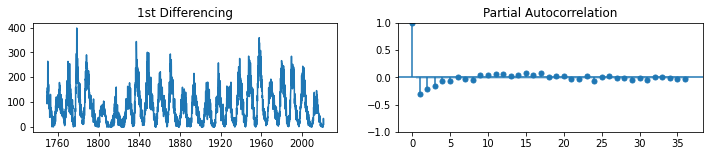

In [23]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,2)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

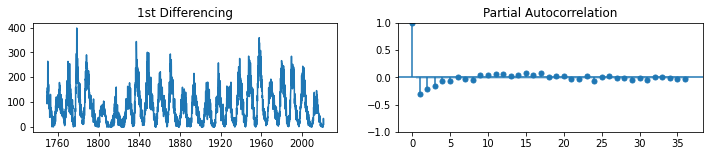

In [24]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,2)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

To find the 'p' value, we observe where the Partial Autocorellation Function crosses the upper confidence interval, in our case, is close to 1. Therefore, p = 1. 

#### Finding the order of the MA term (q)

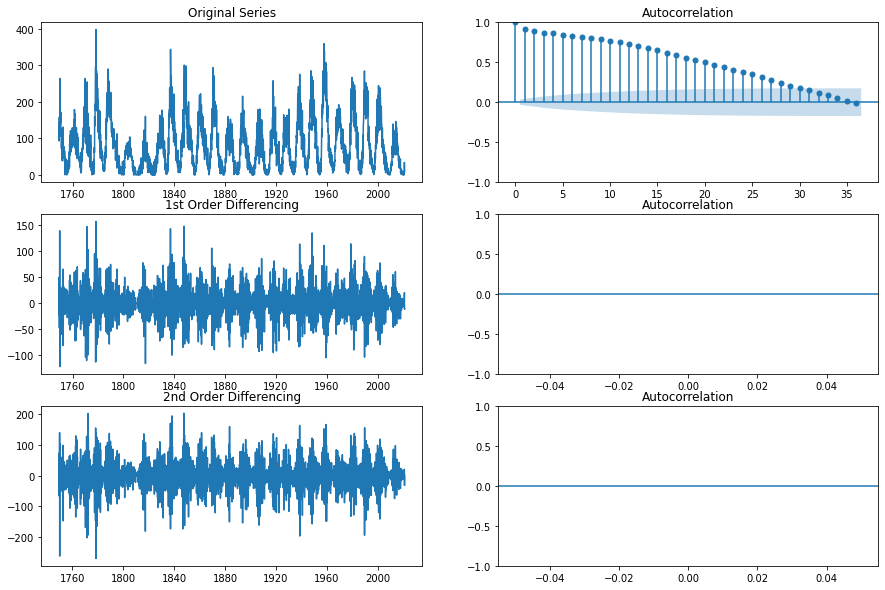

In [63]:
plt.rcParams.update({'figure.figsize':(15,10)})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df)
axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff(), ax=axes[2, 1]);

Since there is no autocorrelation in the first and second order differencing, let's try q = 1.

#### Final p, q, d choices = (1, 1, 0)

To choose the best values of p and q, we will try two approaches. The first one was done above, we look at the data and try to estimate the best values. The second one we will try all possible combinations of 'p' and 'q'. To check which values yields the best forecast, we will use the Akaike’s Information Criterion (AIC). 

Good models are obtained by minimising the AIC.   

"It is important to note that these information criteria tend not to be good guides to selecting the appropriate order of differencing (d) of a model, but only for selecting the values of p and q. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable. So we need to use some other approach to choose d, and then we can use the AIC to select p and q." - Forecast: Principles and Practices, 2013. 

#### Calculating the AIC value of our coeficients

In [64]:
# 1,1,0 ARIMA Model
model_fit110 = ARIMA(train_data, order=(1,1,0)).fit()
print(model_fit110.summary())

                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2612
Model:                                ARIMA(1, 1, 0)   Log Likelihood              -12275.901
Date:                               Fri, 15 Jul 2022   AIC                          24555.803
Time:                                       09:36:13   BIC                          24567.538
Sample:                                   01-31-1749   HQIC                         24560.054
                                        - 08-31-1966                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3049      0.014    -22.359      0.000      -0.332      -0.278
sigma2     

Our AIC value is 2455.803. Now, let's try another method to define p and q to see if there is another combination of p and q value that yields a lower AIC. 

#### Testing all the possible combinations

In [27]:
aic_finder(train_data, d=0)

,"p, q, d",AIC
0,"(3, 1, 0)",24388
1,"(3, 0, 0)",24414
2,"(2, 1, 0)",24442
3,"(2, 0, 0)",24506
4,"(1, 1, 0)",24555


Our choice (1,1,0) returned one of the best values for AIC.   
Nevertheless, the lowest AIC values was when (3, 1, 0) so we should've choose p = 3 instead of p = 1. 

#### Best parameters: p = 3, q = 1, d = 0

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

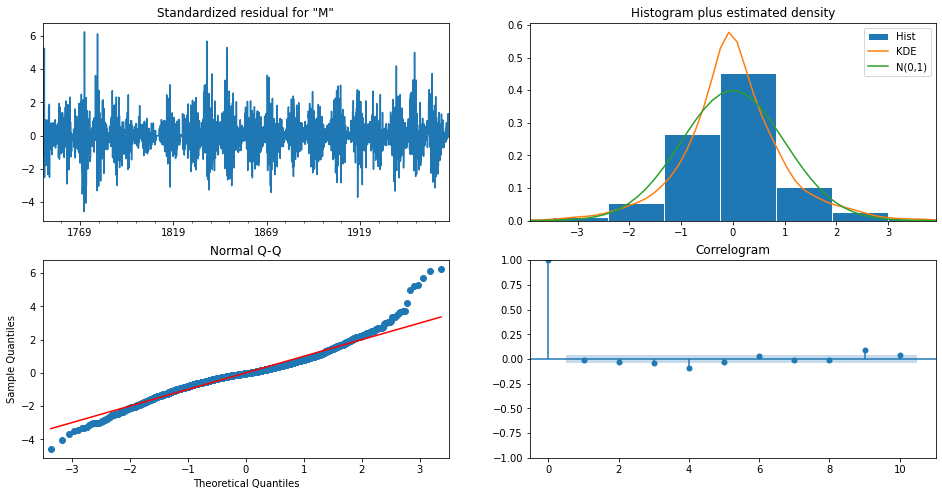

In [28]:
model_fit310 = ARIMA(train_data, order=(3,1,0)).fit()
model_fit310.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

#### Plotting the graph

In [47]:
# model_fit310 = ARIMA(train_data, order=(3,1,0)).fit().predict(start=)
arima_310 = model_fit310.predict(start=pd.to_datetime('1966-09-30'), end=pd.to_datetime('2021-01-31'))
arima_310

1966-09-30    71.849589
1966-10-31    72.318479
1966-11-30    73.433706
1966-12-31    72.975672
1967-01-31    72.798230
                ...    
2020-09-30    72.890821
2020-10-31    72.890821
2020-11-30    72.890821
2020-12-31    72.890821
2021-01-31    72.890821
Freq: M, Name: predicted_mean, Length: 653, dtype: float64

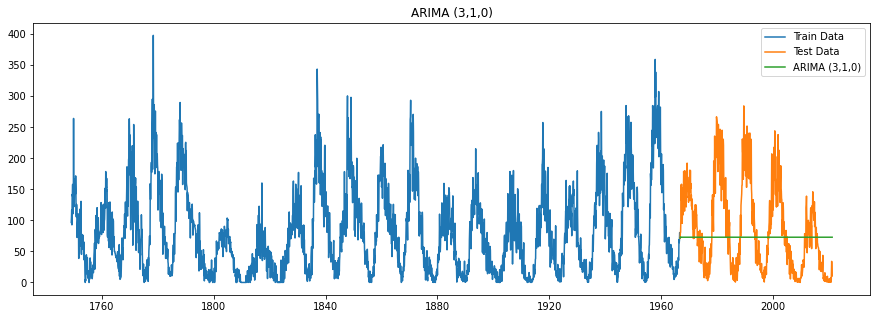

In [52]:
plt.figure(figsize=(15,5))
plt.title('ARIMA (3,1,0)')
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.plot(arima_310, label='ARIMA (3,1,0)')
plt.legend(loc='best')
plt.show()

#### Calculating RMSE and MAE

In [53]:
forecast_error(test_data, arima_310)

{'Model': 'model_name', 'RMSE': 70.64, 'MAE': 57.97}

<hr>

# 8. Conclusion

#### Comparing all the erros from the models

In [58]:
error_results = []
error_results.append(forecast_error(test_data, naive_model, 'Naive Model'))
error_results.append(forecast_error(test_data, y_hat_mean, 'Mean Model'))
error_results.append(forecast_error(test_data, fcast_2, 'Exp_Smoothing'))
error_results.append(forecast_error(test_data, arima_310, 'ARIMA (3,1,0)'))
error_results = pd.DataFrame(error_results)

In [59]:
error_results

,Model,RMSE,MAE
0,Naive Model,103.10,77.83
1,Mean Model,69.44,58.36
2,Exp_Smoothing,70.58,57.97
3,"ARIMA (3,1,0)",70.64,57.97


Is interesting to see that all the models generated had similar error. We normally expect that the ARIMA model would yield the best result, however, that was not the case. We had two factors that contributed for this conclusion: the first one was that our data was very noisy and had some exogenous variables that played a big role. The second factor was the length of the dataset, and, consequently the number of steps (653) forecasted, with too many steps, the ARIMA model tends to a fix value (like the mean model or the exponential smoothing).
    
One way that maybe we can get better results, is to resample the database to use yearly data instead of monthly data. 

<hr>

# 9. Bibliography

* Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. [DOI]
*[ Forecasting: principles and practice, 2013](https://otexts.com/fpp2/).
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/
